# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9792 / 11441 MB available


In [4]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols){
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    // Some pseudo-code..
    // c[j,i] = a[j,i] + b[j,i]
    unsigned int k = j*cols + i; // linear index
    
    c[k] = a[k] + b[k];
}

// Create kernel that creates c = A*b
__global__ void matrixVectorKernel(float* a, float* b, float* c, int a_cols) {
  // note: write for loops that compute the vector-vector inner product of row "j" (of A)
  // by vector "b", and store the result in "c[j]"
  
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    unsigned int k;
    
  //  // Previous version
  //  c[j] = 0.;
  //  for(int i = 0; i < a_cols; ++i) {
  //    k = j*a_cols + i;
  //    c[j] += a[k]*b[i]; // HEY IT'S INEFFICIENT!!!!
  //  }
  
    float sum = 0.0f; // this is a local variable, that lives in the local register!
    for (int i = 0; i < a_cols; ++a) {
      k = j*a_cols + i;
      sum += a[k]*b[i];
    }
    c[j] = sum; // writes to global memory, the RAM (!)
}

"""
module = cuda_compiler.SourceModule(cuda_kernel)
# kernel = module.get_function("addVectorKernel");
# kernel = module.get_function("addMatrixKernel");
kernel = module.get_function("matrixVectorKernel");
print("Seems fine\n")


Seems fine



In [5]:
# THe one here is just CPU code..
#Size of our test
# test_size = (64, 128)
# test_size = (16, 24)
test_size = (4, 3)
# n = 50

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
print(a.shape)

(4, 3)


(3, 1)
(4, 1)


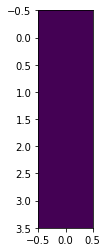

In [6]:
b = np.random.random((test_size[1],1)).astype(np.float32)
print(b.shape)
# c = np.random.random((test_size[0],1)).astype(np.float32)
c = np.empty((test_size[0],1)).astype(np.float32)
print(c.shape)
plt.figure()
plt.imshow(c)
plt.show()

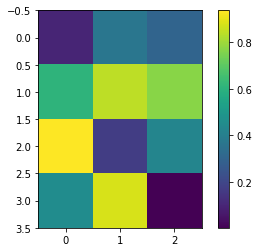

In [8]:
# fig = plt.figure(figsize=(12,8))
fig = plt.figure()
plt.imshow(a)
plt.colorbar()
fig.show()

In [9]:
print(a.shape) # let's check what I'll send to the GPU... 

(4, 3)


In [10]:
#Upload data to the device
# NOTE: we need to make sure that a=(a_rows, a_cols) and that b=(a_cols,1) and 
# c=(a_rows,1)
a_g = GPUArray(a.shape, np.float32) # create the variable
b_g = GPUArray(b.shape, np.float32) # create the variable
a_g.set(a) # put the value (import from CPU to GPU)
b_g.set(b) # put the value (import from CPU to GPU)

In [11]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)
print(c_g.shape) # test..

(4, 1)


In [12]:
# Let's create a couple of variables..
# a.shape is [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0]) # now the domain_size is [x,y]
# Note: change so that x = 1, y = number of rows in "a"
block_size = (1, 1, 1)
grid_size = (1, c.shape[0], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (3, 4)
Block size is (1, 1, 1)
Grid size is (1, 4, 1)


In [13]:
print(a.shape)

(4, 3)


In [ ]:
#Execute program on device
# ATTENTION! SPECIFY int32!!!
kernel(c_g, a_g, b_g, np.int32(a.shape[1]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

In [ ]:
#Compute reference using Numpy
c_ref = np.dot(a,b)

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)
#plt.plot(c, '+r')
#plt.plot(c_ref, 'xb')